# Imports

In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.utils import load_img
from PIL import Image
from tqdm import tqdm
import os

C:\Users\PC\anaconda3\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## GPU Memory Limit

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Age Detection

In [4]:
image_paths = []
age_labels = []
gender_labels = []
BASE_DIR = '../face_gender_age_detection/UTKFace/UTKFace'

for file in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, file)
    age_gender = file.split('_')
    age = int(age_gender[0])
    image_paths.append(image_path)
    age_labels.append(age)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 348566.00it/s]


In [5]:
len(image_paths), len(age_labels)

(23708, 23708)

In [6]:
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

,image,age
0,../face_gender_age_detection/UTKFace/UTKFace\1...,100
1,../face_gender_age_detection/UTKFace/UTKFace\1...,100
2,../face_gender_age_detection/UTKFace/UTKFace\1...,100
3,../face_gender_age_detection/UTKFace/UTKFace\1...,100
4,../face_gender_age_detection/UTKFace/UTKFace\1...,100


In [7]:
under4s = []

for i in range(len(df)):
    if df['age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

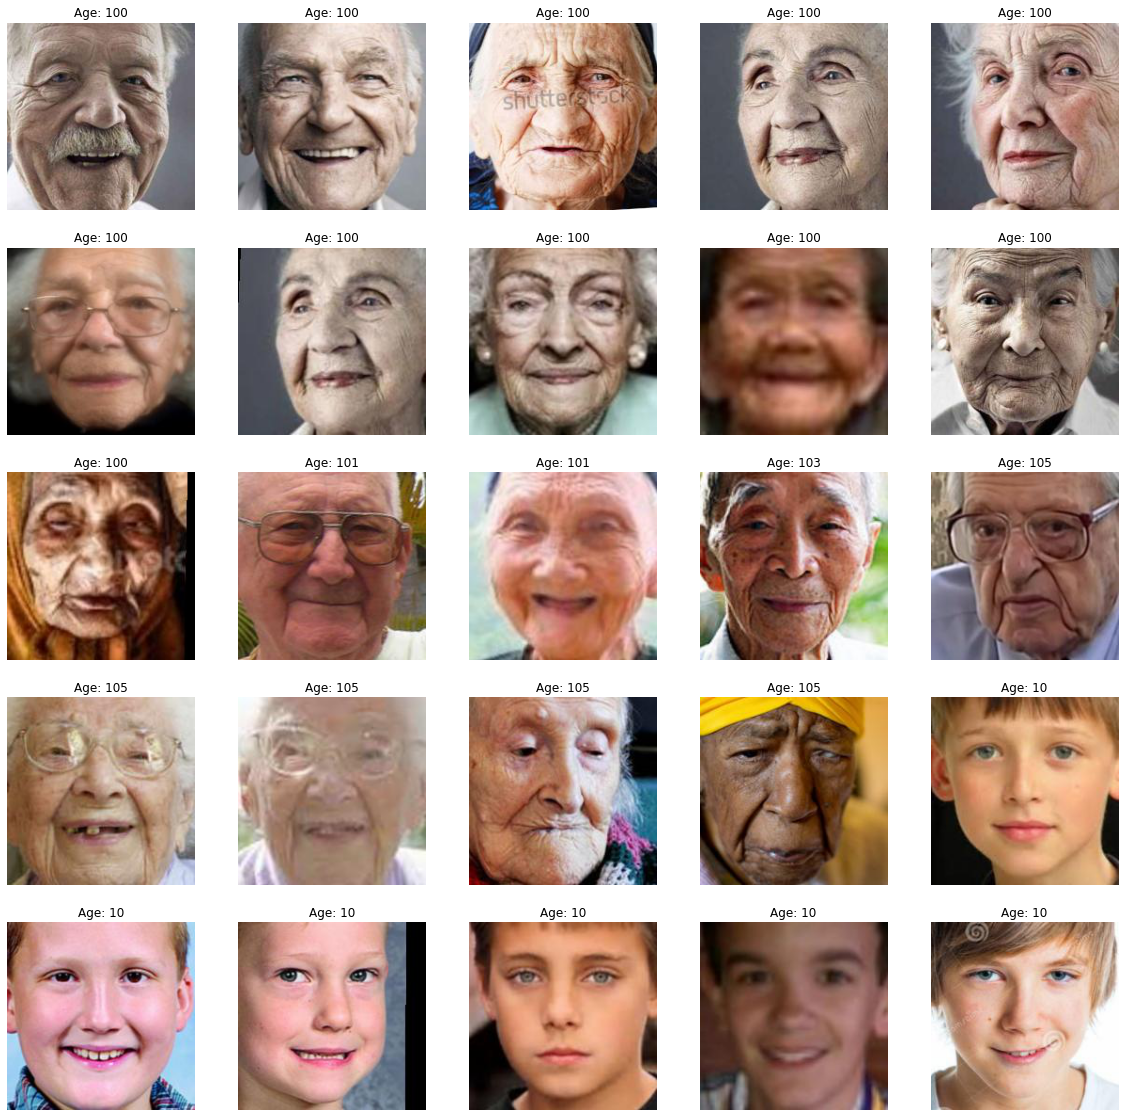

In [8]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]
for index, file, age in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)

In [41]:
X_train = []
for image in tqdm(train['image']):
    img = load_img(image)
    img = img.resize((120, 120), Image.Resampling.LANCZOS)
    img = np.array(img)
    X_train.append(img)

X_train = np.array(X_train)
# ignore this step if using RGB
# X_train = X_train.reshape(len(X_train), 120, 120, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17752/17752 [00:22<00:00, 788.97it/s]


In [42]:
X_train.shape

(17752, 120, 120, 3)

In [43]:
X_train = X_train/255.0 # Normalizing the images

In [44]:
age_dict = {0: '0-14', 1: '15-25', 2: '26-40', 3: '41-65', 4:'66-100', 5:'101+'}
def label_age(age_list):
    y_age = []
    for age in np.array(age_list):
        if 0 <= age <= 14:
            y_age.append(0)
        elif 15 <= age <= 35:
            y_age.append(1)
        elif 26 <= age <= 40:
            y_age.append(2)
        elif 41 <= age <= 65:
            y_age.append(3)
        elif 66 <= age <= 100:
            y_age.append(4)
        else:
            y_age.append(5)
    return np.array(y_age)

In [45]:
y_train_age = label_age(train['age'])
y_train_age.shape

(17752,)

In [46]:
train['age_class'] = y_train_age

In [47]:
train

,image,age,age_class
2309,../face_gender_age_detection/UTKFace/UTKFace\2...,22,1
14635,../face_gender_age_detection/UTKFace/UTKFace\4...,45,3
3528,../face_gender_age_detection/UTKFace/UTKFace\2...,24,1
18768,../face_gender_age_detection/UTKFace/UTKFace\6...,63,3
9516,../face_gender_age_detection/UTKFace/UTKFace\3...,30,1
...,...,...,...
6941,../face_gender_age_detection/UTKFace/UTKFace\2...,27,1
21047,../face_gender_age_detection/UTKFace/UTKFace\8...,8,0
10805,../face_gender_age_detection/UTKFace/UTKFace\3...,34,1
18636,../face_gender_age_detection/UTKFace/UTKFace\6...,61,3


In [48]:
y_train_age = pd.get_dummies(train['age_class'])

In [49]:
y_train_age

,0,1,2,3,4,5
2309,0,1,0,0,0,0
14635,0,0,0,1,0,0
3528,0,1,0,0,0,0
18768,0,0,0,1,0,0
9516,0,1,0,0,0,0
...,...,...,...,...,...,...
6941,0,1,0,0,0,0
21047,1,0,0,0,0,0
10805,0,1,0,0,0,0
18636,0,0,0,1,0,0


In [50]:
X_test = []
for image in tqdm(test['image']):
    img = load_img(image)
    img = img.resize((120, 120), Image.Resampling.LANCZOS)
    img = np.array(img)
    X_test.append(img)

X_test = np.array(X_test)
# ignore this step if using RGB
# X_test = X_test.reshape(len(X_test), 120, 120, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4439/4439 [00:06<00:00, 671.24it/s]


In [51]:
X_test = X_test/255.0 # Normalizing the images

In [52]:
y_test_age = label_age(test['age'])

In [53]:
test['age_class']  = y_test_age

In [54]:
test

,image,age,age_class
20548,../face_gender_age_detection/UTKFace/UTKFace\8...,80,4
1265,../face_gender_age_detection/UTKFace/UTKFace\1...,18,1
11985,../face_gender_age_detection/UTKFace/UTKFace\3...,35,1
6435,../face_gender_age_detection/UTKFace/UTKFace\2...,26,1
9990,../face_gender_age_detection/UTKFace/UTKFace\3...,32,1
...,...,...,...
4602,../face_gender_age_detection/UTKFace/UTKFace\2...,25,1
19223,../face_gender_age_detection/UTKFace/UTKFace\6...,66,4
9058,../face_gender_age_detection/UTKFace/UTKFace\3...,30,1
14515,../face_gender_age_detection/UTKFace/UTKFace\4...,43,3


In [55]:
y_test_age = pd.get_dummies(test['age_class'])

In [56]:
np.array(y_test_age)

array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [57]:
input_shape = (120, 120, 3)

In [61]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [62]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(120,120,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
history_age = model.fit(X_train, np.array(y_train_age), batch_size=64, epochs=25)
model.save('agemodel')
# model_age = tf.keras.models.load_model('agemodel')

Epoch 1/25
278/278 [==============================] - 13s 36ms/step - loss: 1.4076 - accuracy: 0.5169
Epoch 2/25
278/278 [==============================] - 10s 36ms/step - loss: 1.0702 - accuracy: 0.6020
Epoch 3/25
278/278 [==============================] - 10s 35ms/step - loss: 0.9814 - accuracy: 0.6297
Epoch 4/25
278/278 [==============================] - 10s 35ms/step - loss: 0.9238 - accuracy: 0.6533
Epoch 5/25
278/278 [==============================] - 10s 35ms/step - loss: 0.8880 - accuracy: 0.6666
Epoch 6/25
278/278 [==============================] - 10s 35ms/step - loss: 0.8625 - accuracy: 0.6746
Epoch 7/25
278/278 [==============================] - 10s 35ms/step - loss: 0.8391 - accuracy: 0.6873
Epoch 8/25
278/278 [==============================] - 10s 35ms/step - loss: 0.8121 - accuracy: 0.6933
Epoch 9/25
278/278 [==============================] - 10s 35ms/step - loss: 0.7871 - accuracy: 0.7019
Epoch 10/25
278/278 [==============================] - 10s 35ms/step - loss: 0.772

INFO:tensorflow:Assets written to: agemodel\assets


INFO:tensorflow:Assets written to: agemodel\assets


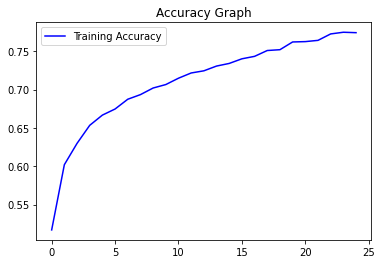

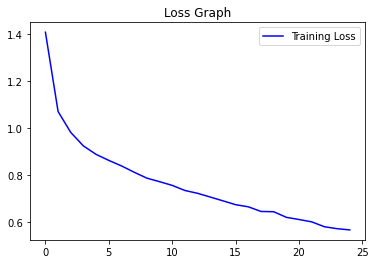

In [64]:
# plot results for age
acc = history_age.history['accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history_age.history['loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [65]:
pred_age = model.predict(X_test)

139/139 [==============================] - 1s 5ms/step


In [68]:
pred_age.reshape(4439, 6).shape

(4439, 6)

In [69]:
pred_df_image = pd.DataFrame(test['image'])
pred_df_image = pred_df_image.reset_index(drop=True)

pred_df = pd.DataFrame(pred_age)
pred_df['image'] = pred_df_image['image']

In [70]:
pred_df

,0,1,2,3,4,5,image
0,6.889086e-04,0.048288,0.104240,0.683542,1.630445e-01,1.966889e-04,../face_gender_age_detection/UTKFace/UTKFace\8...
1,4.297956e-02,0.920822,0.026524,0.009675,5.310192e-09,8.170672e-17,../face_gender_age_detection/UTKFace/UTKFace\1...
2,1.789592e-05,0.807540,0.132634,0.059805,3.538883e-06,9.195908e-15,../face_gender_age_detection/UTKFace/UTKFace\3...
3,2.895776e-07,0.988018,0.007996,0.003986,1.712062e-07,7.337022e-20,../face_gender_age_detection/UTKFace/UTKFace\2...
4,4.763257e-06,0.382541,0.267883,0.349374,1.974040e-04,7.435310e-12,../face_gender_age_detection/UTKFace/UTKFace\3...
...,...,...,...,...,...,...,...
4434,2.384654e-06,0.722774,0.102193,0.173357,1.673987e-03,7.952777e-11,../face_gender_age_detection/UTKFace/UTKFace\2...
4435,1.694575e-02,0.031383,0.007363,0.425842,5.065244e-01,1.194209e-02,../face_gender_age_detection/UTKFace/UTKFace\6...
4436,4.730312e-03,0.846872,0.082979,0.065415,3.703966e-06,2.183339e-12,../face_gender_age_detection/UTKFace/UTKFace\3...
4437,4.511575e-04,0.563845,0.318123,0.117576,5.862050e-06,2.868826e-13,../face_gender_age_detection/UTKFace/UTKFace\4...


In [71]:
y_train_age

,0,1,2,3,4,5
2309,0,1,0,0,0,0
14635,0,0,0,1,0,0
3528,0,1,0,0,0,0
18768,0,0,0,1,0,0
9516,0,1,0,0,0,0
...,...,...,...,...,...,...
6941,0,1,0,0,0,0
21047,1,0,0,0,0,0
10805,0,1,0,0,0,0
18636,0,0,0,1,0,0


In [72]:
correct_age = 0
count = 0

for img in tqdm(range(len(y_test_age))):
    predict_index = np.argmax(pred_age[count])
    true_index = np.argmax(np.array(y_test_age)[count])
    if true_index == predict_index:
        correct_age += 1
        
    count += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4439/4439 [00:00<00:00, 92457.85it/s]


In [73]:
correct_age, (len(y_test_age) - correct_age)

(3269, 1170)

In [74]:
age_pred_accuracy = (correct_age * 100) / len(y_test_age)
age_pred_accuracy

73.64271232259517

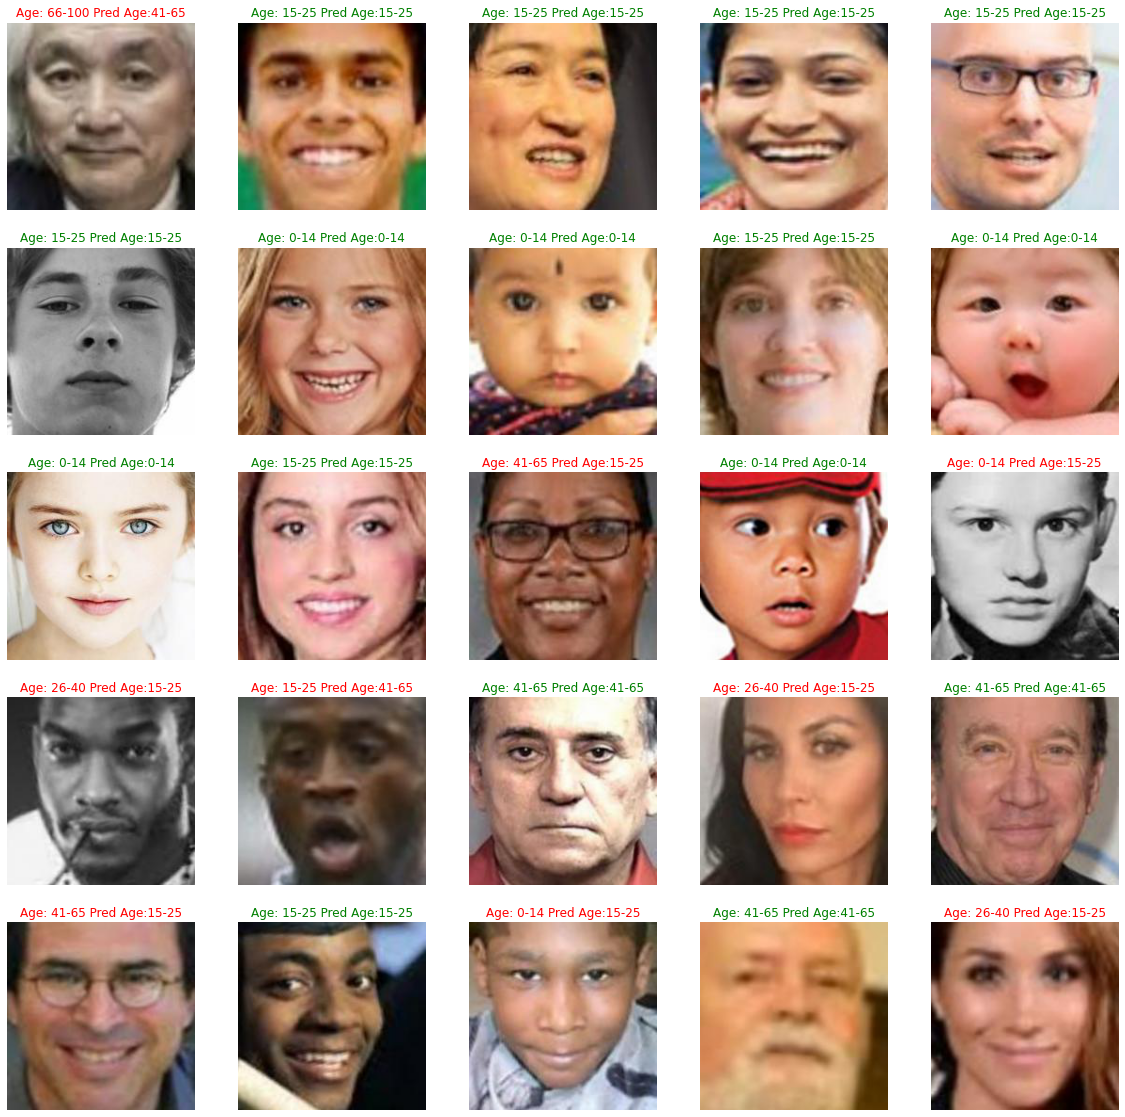

In [75]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = test.reset_index(drop=True).iloc[0:25]
for index, file, age, age_class in files.itertuples():
    plt.subplot(5, 5, (index % 25) + 1)
    img = load_img(file)
    img = np.array(img)
    predict_index = np.argmax(pred_age[index])
    plt.imshow(img)
    plt.title(f"Age: {age_dict[age_class]} Pred Age:{age_dict[predict_index]}",color=("green" if age_dict[age_class] == age_dict[predict_index] else "red"))
    plt.axis('off')

In [ ]:
# for 9 classes the model accuracy was %53.74287175921432
# for 7 classes the model accuracy was %69.63280018022077
# for 6 classes the model accuracy was %73.64271232259517
# for 4 classes the model accuracy was %100.0